In [111]:
from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.utils import class_weight


In [112]:
NUMBER_OF_CLASSES = 6
EPOCHS = 50

TRAINING_PATH = "../data_collection/datasets/training"
TEST_PATH = "../data_collection/datasets/test"

x_training = np.load(os.path.join(TRAINING_PATH, "class", "features.npy"), allow_pickle=True)
x_training = np.array([x_training[i].T for i in range(x_training.shape[0])])[-900:]
y_training = np.load(os.path.join(TRAINING_PATH, "class", "labels.npy"), allow_pickle=True)[-900:]

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_training), y=y_training)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))
class_weights = tf.cast(tf.constant(class_weights), "float32")

INPUT_DIM = x_training.shape[1:]

x_training = tf.convert_to_tensor(x_training.astype('float32'))
y_training = tf.convert_to_tensor(y_training.astype('int32'))

# x_training = x_training.astype('float32')
# y_training = y_training.astype('int32')
# y_training = tf.one_hot(y_training, 5)



In [114]:
def weightedLoss(weights=tf.constant([1,1,1,1,1,1])):
    def innerLoss(true, pred):
        w = tf.gather(weights, true) #(batch, labels, 1)

        loss = tf.keras.backend.sparse_categorical_crossentropy(true, pred) #(batch, labels)
        loss = w * loss

        return loss

    return innerLoss

In [184]:
class_weights_dict[2]=0.01
class_weights_dict[3]=0.01

In [185]:

def create_mlp_model(input_shape:Tuple[int, int], 
                     layer_number:int, 
                     neuron_number:List[int], 
                     activation:str|None="relu",
                     loss:str|None = "mae",
                     optimizer:str|None="adam") -> tf.keras.Model:

    """Creates a simple MLP regression model with 3-layers."""
    print(loss)

    layers = [tf.keras.layers.Dense(neuron_number[i], activation=activation) for i in range(layer_number)]
    layers.insert(0, tf.keras.layers.InputLayer(input_shape=input_shape))
    layers.insert(1, tf.keras.layers.Flatten())
    layers.append(tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation="softmax"))
    # layers.append(tf.keras.layers.Maximum())

    model = tf.keras.Sequential(layers)
    model.compile(
        # loss=loss,
        loss=weightedLoss(class_weights),
        optimizer=tf.keras.optimizers.legacy.Adagrad(learning_rate=0.009),
        metrics=["acc"]
    )

    return model

In [186]:
model = create_mlp_model(INPUT_DIM, 10, [128, 64, 32, 128, 64, 32, 128, 64 ,32, 16], activation="tanh", loss="sparse_categorical_crossentropy", optimizer="adam")

sparse_categorical_crossentropy


In [187]:
## model training 
history = model.fit(x_training, y_training, epochs=EPOCHS, batch_size=64, verbose=1, validation_split=0.10, class_weight=class_weights_dict)

Epoch 1/50
13/13 [==============================] - 1s 46ms/step - loss: 1.8937 - acc: 0.2457 - val_loss: 1.6600 - val_acc: 0.2778
Epoch 2/50
13/13 [==============================] - 0s 13ms/step - loss: 1.8077 - acc: 0.2951 - val_loss: 1.6418 - val_acc: 0.3111
Epoch 3/50
13/13 [==============================] - 0s 12ms/step - loss: 1.7923 - acc: 0.2827 - val_loss: 1.6487 - val_acc: 0.3111
Epoch 4/50
13/13 [==============================] - 0s 10ms/step - loss: 1.8083 - acc: 0.2827 - val_loss: 1.6223 - val_acc: 0.3111
Epoch 5/50
13/13 [==============================] - 0s 10ms/step - loss: 1.7919 - acc: 0.2889 - val_loss: 1.6354 - val_acc: 0.3111
Epoch 6/50
13/13 [==============================] - 0s 13ms/step - loss: 1.7940 - acc: 0.2753 - val_loss: 1.6382 - val_acc: 0.2889
Epoch 7/50
13/13 [==============================] - 0s 10ms/step - loss: 1.7903 - acc: 0.2728 - val_loss: 1.6356 - val_acc: 0.3111
Epoch 8/50
13/13 [==============================] - 0s 10ms/step - loss: 1.7962 - a

In [188]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 792)               0         
                                                                 
 dense_122 (Dense)           (None, 128)               101504    
                                                                 
 dense_123 (Dense)           (None, 64)                8256      
                                                                 
 dense_124 (Dense)           (None, 32)                2080      
                                                                 
 dense_125 (Dense)           (None, 128)               4224      
                                                                 
 dense_126 (Dense)           (None, 64)                8256      
                                                                 
 dense_127 (Dense)           (None, 32)              

In [189]:
accuracy = history.history["acc"]
val_accuracy = history.history["val_acc"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

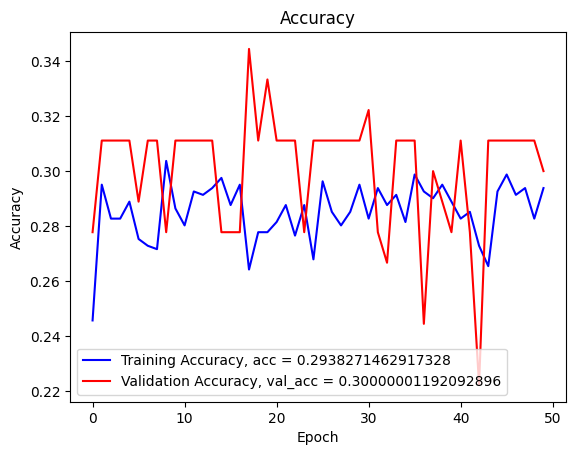

In [190]:
plt.plot(range(EPOCHS), accuracy, "b", label = f"Training Accuracy, acc = {accuracy[-1]}")
plt.plot(range(EPOCHS), val_accuracy, "-r", label = f"Validation Accuracy, val_acc = {val_accuracy[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

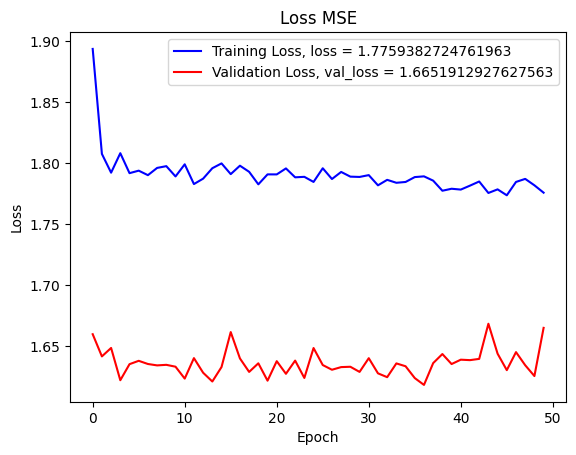

In [191]:
plt.plot(range(EPOCHS), loss, "b", label = f"Training Loss, loss = {loss[-1]}")
plt.plot(range(EPOCHS), val_loss, "-r", label = f"Validation Loss, val_loss = {val_loss[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss MSE")
plt.show()

In [192]:
x_test = np.load(os.path.join(TEST_PATH, "class", "features.npy"), allow_pickle=True)
x_test = np.array([x_test[i].T for i in range(x_test.shape[0])])
y_test = np.load(os.path.join(TEST_PATH, "class", "labels.npy"), allow_pickle=True)  

x_test = tf.convert_to_tensor(x_test.astype('float32'))
y_test = tf.convert_to_tensor(y_test.astype('int32'))

In [193]:
y_test

<tf.Tensor: shape=(395,), dtype=int32, numpy=
array([3, 0, 3, 3, 1, 1, 4, 3, 1, 5, 0, 1, 1, 0, 0, 5, 0, 1, 3, 3, 4, 1,
       3, 1, 3, 2, 3, 3, 2, 3, 2, 1, 2, 3, 3, 4, 2, 2, 3, 2, 3, 3, 3, 2,
       2, 2, 2, 2, 2, 1, 2, 3, 1, 3, 2, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 2, 5, 2, 2, 3,
       2, 3, 3, 0, 3, 5, 4, 2, 2, 2, 1, 3, 2, 2, 5, 2, 3, 4, 1, 4, 3, 3,
       3, 2, 2, 2, 2, 3, 0, 2, 3, 3, 3, 2, 3, 0, 2, 2, 4, 2, 3, 3, 2, 2,
       3, 3, 1, 4, 3, 5, 4, 2, 1, 0, 5, 0, 1, 4, 0, 4, 1, 0, 5, 3, 2, 2,
       4, 2, 3, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3,
       2, 2, 2, 3, 3, 4, 2, 5, 5, 1, 4, 4, 2, 2, 3, 0, 3, 5, 2, 0, 2, 0,
       0, 5, 2, 1, 1, 3, 3, 1, 2, 3, 3, 0, 1, 4, 4, 3, 2, 3, 2, 1, 4, 5,
       2, 3, 1, 4, 2, 3, 2, 4, 2, 3, 2, 3, 3, 2, 2, 0, 3, 2, 2, 4, 2, 3,
       3, 3, 2, 3, 2, 1, 3, 2, 2, 3, 4, 3, 5, 1, 5, 2, 5, 5, 5, 5, 5, 5,
       5, 3, 5, 1, 0, 5, 5, 1, 3, 2, 0, 4, 2, 2, 2, 4, 1, 3, 4, 3, 3, 3,
     

In [194]:
model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 11ms/step - loss: 1.5820 - acc: 0.2987


[1.582025408744812, 0.298734188079834]

In [195]:
from sklearn.metrics import classification_report, confusion_matrix

In [198]:
#Predict
y_prediction = model.predict(x_test)

y_prediction = np.argmax (y_prediction, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(classification_report(y_test, y_prediction))
print(result)

13/13 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.00      0.00      0.00        37
           2       0.46      0.04      0.08       135
           3       0.29      0.97      0.45       115
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        45

    accuracy                           0.30       395
   macro avg       0.13      0.17      0.09       395
weighted avg       0.24      0.30      0.16       395

[[0.         0.         0.07692308 0.08376963 0.         0.        ]
 [0.         0.         0.15384615 0.09162304 0.         0.        ]
 [0.         0.         0.46153846 0.33769634 0.         0.        ]
 [0.         0.         0.23076923 0.29319372 0.         0.        ]
 [0.         0.         0.07692308 0.07591623 0.         0.        ]
 [0.         0.         0.         0.11780105 0.         0.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [143]:
np.unique(y_prediction, return_counts=True)

(array([3]), array([395]))

In [144]:
y_prediction.shape

(395,)

In [145]:
y_prediction[200:300]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [146]:
np.unique(y_training, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([ 82,  83, 246, 266, 114, 109]))